In [29]:
import requests
from bs4 import BeautifulSoup
# !pip install pycountry
import pycountry
import pandas as pd
import numpy as np
import json

In [2]:
import matplotlib.pyplot as plt
from matplotlib import *
import seaborn as sns

In [3]:
# !pip install matplotlib-venn

In [4]:
# !pip install upsetplot

In [5]:
# from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
# from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline

# Popularity-weighted blocking metric.

Our goal here is to produce a *directed* measure of country-to-country website blocking.

To illustrate our point,
here's a thought experiment: if a Norwegian goes to Indonesia, would they
actually notice that anything is blocked? If Indonesia blocks mostly Indonesian-language content, perhaps not. What if an American goes to China? Since China blocks most popular US websites, they probably will!

We measure this X-to-Y country-to-country comparison here. Our initial goal, upon starting, is to suss out international conflict points.

We'll do this measurement by finding the most *popular* websites in each country, according to Alexa.
Then, for each country, we see which other countries block those popular sites. The intuition here is that blocking Wikipedia is a bigger deal than blocking some tiny political website, since the former is more popular (i.e., widely-visited) than the latter.


## Website blocking data
You'll need to [download iclab-clean-fortiguard.csv here](https://berkeley.box.com/s/je4ld219m7somvqmb9bqu2v7z3il3n48).

Alternatively, if you want to produce this file yourself (i.e., to replicate our work), just run `bloging-pattern-similarity-metric.ipynb` in this repository.


In [6]:
iclabClean1 = pd.read_csv('../data/iclab_cleaned_data/iclab-cleaned-fortiguard.csv')

/home/ffff/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Alexa data

In [7]:
def top_sites_in (country_code):
    """
    Finds the top Alex sites by Alexa ranking in a given country.
    Parameter:
        country_code - country whose top sites we are finding based on Alexa ratings
    Returns:
        List of Top Websites in the country 
    """
    
    def process_row (tds):
        rank = int(tds[0].get_text())
        url = tds[1].find('a').get_text('siteinfo').lower()
        daily_time =  tds[2].get_text()
        daily_pageviews_per_visitor =  float(tds[3].get_text())
        perc_traffic_from_search =  float(tds[4].get_text().replace('%', ''))/100
        total_sites_linking_in =  int(tds[5].get_text().replace(',', ''))
        return [rank, url, daily_time, daily_pageviews_per_visitor, perc_traffic_from_search, total_sites_linking_in]
    
    # Scraping Top Sites list from Alexa for country 
    url = "https://www.alexa.com/topsites/countries/" + country_code
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    divs = soup.find_all('div', class_='tr site-listing')
    
    rankings = []
    for div in divs:
        tds = div.find_all('div', class_='td')
        rankings.append(process_row(tds))
    return pd.DataFrame(
        rankings,
        columns = [
            'rank',
            'url',
            'daily_time_on_site_per_visitor',
            'daily_pageviews_per_visitor',
            'perc_traffic_from_search',
            'total_sites_linking_in'
        ])

top_sites_in('US')

,rank,url,daily_time_on_site_per_visitor,daily_pageviews_per_visitor,perc_traffic_from_search,total_sites_linking_in
0,1,google.com,15:43,17.09,0.004,1300441
1,2,youtube.com,16:54,9.68,0.149,988820
2,3,amazon.com,10:26,9.73,0.195,363277
3,4,yahoo.com,5:02,4.65,0.081,319186
4,5,facebook.com,18:52,8.83,0.088,2181031
5,6,zoom.us,8:29,3.94,0.127,3009
6,7,reddit.com,5:33,4.38,0.320,163041
7,8,wikipedia.org,3:47,3.04,0.740,763999
8,9,myshopify.com,22:17,14.47,0.030,118
9,10,ebay.com,10:10,8.04,0.164,74970


## Compute metric

In [8]:
def blocked_sites_in (country_code: str) -> set:
    """
    Finds list of unique Blocked websites in a country
    Parameter:
          Country Code
    Returns:
          Set of Blocked Websites in the Country
    """
    
    # Country Specific blocked sites list
    CC_blocked_list = iclabClean1[(iclabClean1['country']==country_code)&(iclabClean1['censored_updated']==True)]['site'].tolist()
    CC_blocked_set = set(CC_blocked_list) # set of blocked sites in the country
    # HACK: manually remove blocked websites in countries known to block nothing
    if country_code in ['US', 'CA']:
        return set([])
    # HACK: manually add websites known to be blocked in CN
    # https://en.wikipedia.org/wiki/List_of_websites_blocked_in_mainland_China
    if country_code=='CN':
        CC_blocked_set = CC_blocked_set.union(set([
            'google.com',
            'youtube.com',
            'byte.co',
            'facebook.com',
            'webtoons.com',
            'crunchyroll.com',
            'wikipedia.org',
            'live.com',
            'netflix.com',
            'blogspot.com',
            'yahoo.co.jp',
            'bing.com',
            'twitch.tv',
            'twitter.com',
            'tumblr.com',
            'pinterest.com',
            'amazon.co.jp',
            'pornhub.com',
            'wionews.com',
            'imgur.com',
            'nytimes.com',
            'archive.org',
            'nbc.com',
            'hbo.com',
        ]))
    
    return CC_blocked_set

blocked_sites_in('CN')

{'163.com',
 '17ok.com',
 '1905.com',
 '360.cn',
 '39.net',
 '3dmgame.com',
 'address.com',
 'allegro.pl',
 'amazon.co.jp',
 'anonymouse.org',
 'archive.org',
 'bing.com',
 'bittornado.com',
 'blogspot.com',
 'byte.co',
 'cameolingerieonline.com',
 'cctv.com',
 'cefc.org',
 'chinaz.com',
 'crunchyroll.com',
 'douyu.com',
 'facebook.com',
 'fanpage.gr',
 'globalvoicesonline.org',
 'google.com',
 'guildwars.com',
 'hbo.com',
 'hgtv.com',
 'hrcr.org',
 'imgur.com',
 'implantinfo.com',
 'indeed.com',
 'instagram.com',
 'jalb.de',
 'kdnet.net',
 'lanacion.com.ar',
 'lineriderfun.com',
 'live.com',
 'nbc.com',
 'netflix.com',
 'nytimes.com',
 'office.com',
 'ohmynews.com',
 'oovoo.com',
 'paypal.com',
 'people.com.cn',
 'pinterest.com',
 'pornhub.com',
 'rarbg.to',
 'rim.net',
 'schwarzreport.org',
 'sectsco.org',
 'sourceforge.net',
 'southwest.com',
 'sozcu.com.tr',
 'tumblr.com',
 'twitch.tv',
 'twitter.com',
 'webtoons.com',
 'weebly.com',
 'whitepages.com',
 'wikipedia.org',
 'wikiwiki.

In [18]:
from time import sleep

# cache for our top websites
# removes need for duplicate queries
top_sites_cache = {}

# cache for sites blocked in particular country
# removes costly df queries
blocked_sites_cache = {}

def blocked_top_sites (countryA: str, countryB: str) -> pd.DataFrame:
    '''
    If a person from Country A goes to Country B, what will be blocked?
    
    Phrased differently, which of country A's top sites are blocked in country B?
    
    Takes:
    - CountryA country code
    - Country B country code
    
    Returns:
    - DataFrame of top sites in country A that are blocked in country B.
    '''
    if countryA in top_sites_cache:
        top = top_sites_cache[countryA]
    else:
        # wait a second to prevent 500
        print('Querying Alexa.com')
        sleep(1)
        top = top_sites_in(countryA)
        top_sites_cache[countryA] = top
    if countryB in blocked_sites_cache:
        blocked = blocked_sites_cache[countryB]
    else:
        blocked = blocked_sites_in(countryB)
        blocked_sites_cache[countryB] = blocked
    return top[top['url'].isin(blocked)]

blocked_top_sites('US', 'CN')

Querying Alexa.com


,rank,url,daily_time_on_site_per_visitor,daily_pageviews_per_visitor,perc_traffic_from_search,total_sites_linking_in
0,1,google.com,15:43,17.09,0.004,1300441
1,2,youtube.com,16:54,9.68,0.149,988820
4,5,facebook.com,18:52,8.83,0.088,2181031
7,8,wikipedia.org,3:47,3.04,0.740,763999
10,11,office.com,9:50,9.34,0.072,5767
11,12,netflix.com,4:20,3.20,0.096,10865
12,13,bing.com,2:52,2.61,0.062,41693
14,15,live.com,5:23,5.33,0.103,43223
18,19,twitch.tv,6:54,3.53,0.070,9771
20,21,instagram.com,8:47,9.71,0.138,622099


In [19]:
blocked_top_sites('US', 'CN')

,rank,url,daily_time_on_site_per_visitor,daily_pageviews_per_visitor,perc_traffic_from_search,total_sites_linking_in
0,1,google.com,15:43,17.09,0.004,1300441
1,2,youtube.com,16:54,9.68,0.149,988820
4,5,facebook.com,18:52,8.83,0.088,2181031
7,8,wikipedia.org,3:47,3.04,0.740,763999
10,11,office.com,9:50,9.34,0.072,5767
11,12,netflix.com,4:20,3.20,0.096,10865
12,13,bing.com,2:52,2.61,0.062,41693
14,15,live.com,5:23,5.33,0.103,43223
18,19,twitch.tv,6:54,3.53,0.070,9771
20,21,instagram.com,8:47,9.71,0.138,622099


In [20]:
# TODO A to B metric
def directed_metric (countryA, countryB):
    '''
    If a person from Country A goes to Country B, what will be blocked?
    This method answers this question with a single number.
    '''
    # TODO 50 is the number of top sites.
    # - set dynamically?
    # - why 50 in the first place?
    # - weight each website diff based on rank, pageviews, etc?
    return blocked_top_sites(countryA, countryB).count().url/50

directed_metric('US', 'CN')

0.28

## Computing metric for all countries

In [21]:
country_names = iclabClean1['country'].unique().tolist()

In [22]:
from itertools import combinations
pairs = combinations(country_names, 2)

metrics = []
for pair in pairs:
    [countryA, countryB] = pair
    print(countryA, countryB)
    try:
        metric = directed_metric(countryA, countryB)
        metrics.append([
            countryA,
            countryB,
            metric
        ])
    except:
        print("Couldn't do", countryA, countryB)

UA CO
Querying Alexa.com
UA KR
UA US
UA BG
UA BZ
UA AU
UA JP
UA NL
UA HK
UA LT
UA RO
UA KE
UA ES
UA VN
UA MX
UA PE
UA SE
UA NZ
UA FR
UA ID
UA ZA
UA HU
UA SK
UA CL
UA CN
UA LU
UA IN
UA SG
UA TW
UA MD
UA NO
UA RU
UA AD
UA CA
UA RS
UA FI
UA MY
UA BE
UA IS
UA VE
UA PT
UA DK
UA CZ
UA IL
UA TR
UA PL
UA DZ
UA BR
UA SC
UA SA
UA AT
UA GR
UA CR
UA LI
CO KR
Querying Alexa.com
CO US
CO BG
CO BZ
CO AU
CO JP
CO NL
CO HK
CO LT
CO RO
CO KE
CO ES
CO VN
CO MX
CO PE
CO SE
CO NZ
CO FR
CO ID
CO ZA
CO HU
CO SK
CO CL
CO CN
CO LU
CO IN
CO SG
CO TW
CO MD
CO NO
CO RU
CO AD
CO CA
CO RS
CO FI
CO MY
CO BE
CO IS
CO VE
CO PT
CO DK
CO CZ
CO IL
CO TR
CO PL
CO DZ
CO BR
CO SC
CO SA
CO AT
CO GR
CO CR
CO LI
KR US
Querying Alexa.com
KR BG
KR BZ
KR AU
KR JP
KR NL
KR HK
KR LT
KR RO
KR KE
KR ES
KR VN
KR MX
KR PE
KR SE
KR NZ
KR FR
KR ID
KR ZA
KR HU
KR SK
KR CL
KR CN
KR LU
KR IN
KR SG
KR TW
KR MD
KR NO
KR RU
KR AD
KR CA
KR RS
KR FI
KR MY
KR BE
KR IS
KR VE
KR PT
KR DK
KR CZ
KR IL
KR TR
KR PL
KR DZ
KR BR
KR SC
KR SA
KR AT
KR GR
K

CA FI
CA MY
CA BE
CA IS
CA VE
CA PT
CA DK
CA CZ
CA IL
CA TR
CA PL
CA DZ
CA BR
CA SC
CA SA
CA AT
CA GR
CA CR
CA LI
RS FI
Querying Alexa.com
RS MY
RS BE
RS IS
RS VE
RS PT
RS DK
RS CZ
RS IL
RS TR
RS PL
RS DZ
RS BR
RS SC
RS SA
RS AT
RS GR
RS CR
RS LI
FI MY
Querying Alexa.com
FI BE
FI IS
FI VE
FI PT
FI DK
FI CZ
FI IL
FI TR
FI PL
FI DZ
FI BR
FI SC
FI SA
FI AT
FI GR
FI CR
FI LI
MY BE
Querying Alexa.com
MY IS
MY VE
MY PT
MY DK
MY CZ
MY IL
MY TR
MY PL
MY DZ
MY BR
MY SC
MY SA
MY AT
MY GR
MY CR
MY LI
BE IS
Querying Alexa.com
BE VE
BE PT
BE DK
BE CZ
BE IL
BE TR
BE PL
BE DZ
BE BR
BE SC
BE SA
BE AT
BE GR
BE CR
BE LI
IS VE
Querying Alexa.com
IS PT
IS DK
IS CZ
IS IL
IS TR
IS PL
IS DZ
IS BR
IS SC
IS SA
IS AT
IS GR
IS CR
IS LI
VE PT
Querying Alexa.com
VE DK
VE CZ
VE IL
VE TR
VE PL
VE DZ
VE BR
VE SC
VE SA
VE AT
VE GR
VE CR
VE LI
PT DK
Querying Alexa.com
PT CZ
PT IL
PT TR
PT PL
PT DZ
PT BR
PT SC
PT SA
PT AT
PT GR
PT CR
PT LI
DK CZ
Querying Alexa.com
DK IL
DK TR
DK PL
DK DZ
DK BR
DK SC
DK SA
DK AT
DK GR
DK

In [23]:
metrics = pd.DataFrame(metrics, 
                      columns=[
                          'countryA_alpha2',
                          'countryB_alpha2',
                          'metric',
                      ])

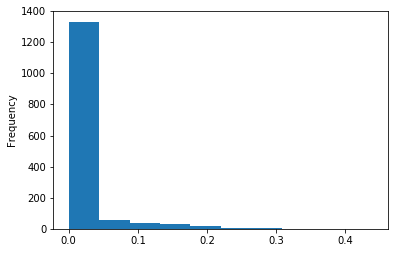

In [26]:
metrics.metric.plot.hist()

### Add alpha3 codes

In [30]:
countries = {}
for country in pycountry.countries:
    countries[country.alpha_2] = country.alpha_3

In [35]:
countryA_alpha3s = []
countryB_alpha3s = []
for i, row in metrics.iterrows():
    countryA_alpha3s.append(countries[row['countryA_alpha2']])
    countryB_alpha3s.append(countries[row['countryB_alpha2']])

In [37]:
metrics['countryA_alpha3'] = countryA_alpha3s
metrics['countryB_alpha3'] = countryB_alpha3s
metrics

,countryA_alpha2,countryB_alpha2,metric,countryA_alpha3,countryB_alpha3
0,UA,CO,0.0,UKR,COL
1,UA,KR,0.3,UKR,KOR
2,UA,US,0.0,UKR,USA
3,UA,BG,0.0,UKR,BGR
4,UA,BZ,0.0,UKR,BLZ
...,...,...,...,...,...
1480,AT,CR,0.0,AUT,CRI
1481,AT,LI,0.0,AUT,LIE
1482,GR,CR,0.0,GRC,CRI
1483,GR,LI,0.0,GRC,LIE


### Write to CSV

In [38]:
metrics.to_csv('../output/metrics_popweight.csv')

# TODO
- observe DIFF between two countries' weights
- find highest-diff (symmetric) pairs
- find highest directed pairs

In [ ]:
allCountries = iclabClean1['country'].unique().tolist()

In [ ]:
BlockDict = {}
for cc in allCountries:
  BlockDict[cc] = BlockedSites(cc)

TopDict = {}
for cc in allCountries:
  TopDict[cc] = TopSites(cc)

In [ ]:
from itertools import combinations
newPairs = [comb for comb in sorted(combinations(allCountries, 2))]

In [ ]:
X2YBlocking={}
for item in newPairs:
  X2YBlocking[item] = BlockedTopSites(TopDict[item[0]],BlockDict[item[1]])

In [ ]:
Y2XBlocking={}
for item in newPairs:
  Y2XBlocking[item] = BlockedTopSites(TopDict[item[1]],BlockDict[item[0]])

### New Proxy DF 

In [ ]:
countries = {}
for country in pycountry.countries:
    countries[country.alpha_2] = country.alpha_3

In [ ]:
ImpactDF = pd.DataFrame(index = newPairs ,columns=['country_code_alpha2_X','country_code_alpha2_Y', 'X2Y_Similarity', 'Y2X_Similarity'	, 'Edge_Asymmetry','Average_Similarity',	'country_code_alpha3_X',	'country_code_alpha3_Y'])
ImpactDF = ImpactDF.reset_index().rename(columns={'index':'pair'})

In [ ]:
ImpactDF['country_code_alpha2_X'] =  ImpactDF['pair'].apply(lambda x: x[0])
ImpactDF['country_code_alpha2_Y'] =  ImpactDF['pair'].apply(lambda x: x[1])
ImpactDF['country_code_alpha3_X'] =  ImpactDF['pair'].apply(lambda x: countries[x[0]])
ImpactDF['country_code_alpha3_Y'] =  ImpactDF['pair'].apply(lambda x: countries[x[1]])

In [ ]:
ImpactDF['X2Y_Similarity'] = ImpactDF['pair'].apply( lambda x : topBlockSimilarity( X2YBlocking[x], Y2XBlocking[x])[0] )
ImpactDF['Y2X_Similarity'] = ImpactDF['pair'].apply( lambda x : topBlockSimilarity(X2YBlocking[x], Y2XBlocking[x])[1] )
ImpactDF['Edge_Asymmetry'] = ImpactDF['pair'].apply( lambda x : topBlockSimilarity(X2YBlocking[x], Y2XBlocking[x])[2] )
ImpactDF['Average_Similarity'] = ImpactDF['pair'].apply( lambda x : topBlockSimilarity(X2YBlocking[x], Y2XBlocking[x])[3] )

In [ ]:
ImpactDF.head()

In [ ]:
ImpactDF.to_csv("ImpactDF.csv")

## 4.3 Directed Asymmetry Viz

X2YBlocking - Set of top sites from Country X which are blocked in Country Y

Y2XBlocking - Set of top sites from Country Y which are blocked in Country X

### Global Comparison

In [ ]:
SourceX = (ImpactDF.groupby('country_code_alpha2_X').mean()).reset_index().drop(columns=['Average_Similarity','Edge_Asymmetry']).rename(columns={'country_code_alpha2_X':'CC','X2Y_Similarity':'VICTIM','Y2X_Similarity':'CULPRIT'})
SourceX.head(2)

In [ ]:
TargetY = (ImpactDF.groupby('country_code_alpha2_Y').mean()).reset_index().drop(columns=['Average_Similarity','Edge_Asymmetry']).rename(columns={'country_code_alpha2_Y':'CC','X2Y_Similarity':'CULPRIT','Y2X_Similarity':'VICTIM'})
TargetY.head(2)

In [ ]:
Cumulative = pd.concat([SourceX,TargetY]).groupby('CC').mean()
Cumulative['AbsDiff'] = abs(Cumulative['VICTIM']-Cumulative['CULPRIT'])
Cumulative['Diff'] = (Cumulative['VICTIM']-Cumulative['CULPRIT'])

In [ ]:
#VICTIM GRAPH
plt.figure(figsize=(30,8))
values = Cumulative['VICTIM'].sort_values() 
idx = Cumulative['VICTIM'].sort_values().index 
plt.title('\n Average similarity when blockED in other countries \n \n (High values indicate that people from THIS country will find the average internet in ALL OTHER countries more similar to their native country \n', size= 20)

ax = sns.barplot(x=idx, y=values, color = 'seagreen') 
plt.xticks(size=15)
plt.show()

In [ ]:
#CULPRIT GRAPH
plt.figure(figsize=(30,8))
values = Cumulative['CULPRIT'].sort_values() 
idx = Cumulative['CULPRIT'].sort_values().index 
plt.title('\n Average similarity when blockING other countries \n \n (Green --> High values indicate that people from OTHER countries will find the average internet in THIS country more similar to their native country \n', size= 20)
plt.xticks(size=15)
ax = sns.barplot(x=idx, y=values,color ='brown') 
plt.show()

In [ ]:
# ABSOLUTE DIFFERENCE GRAPH
# DIFFERENCE = VICTIM - CULPRIT

plt.figure(figsize=(30,8))
values = Cumulative['AbsDiff'].sort_values() 
idx = Cumulative['AbsDiff'].sort_values().index 
plt.title('\n Absolute asymmetry values \n\n Absolute ASYMMETRY = Absolute[Average Similarity(When BlockED In Other Countries) - Average Similarity(When BlockING Other Countries)]\n \n (Green --> Difference greater than global average \n \n', size= 20)
plt.xticks(size=15)
ax = sns.barplot(x=idx, y=values) 

for bar in ax.patches:
    if bar.get_height() >= np.mean(values):
        bar.set_color('green')    
    else:
        bar.set_color('red')

In [ ]:
#DIFFERENCE GRAPH
# DIFFERENCE = VICTIM - CULPRIT

plt.figure(figsize=(30,8))
values = Cumulative['Diff'].sort_values() 
idx = Cumulative['Diff'].sort_values().index 
plt.title('\n ACTUAL ASYMMETRY VALUES \n\n Asymmetry = Average Similarity(When BlockED In Other Countries) - Average Similarity(When BlockING Other Countries)\n \n (GREEN --> Blocks more of other countries stuff than its stuff gets blocked ) \n', size= 20)
plt.xticks(size=15)
ax = sns.barplot(x=idx, y=values) 

for bar in ax.patches:
    if bar.get_height() >= 0:
        bar.set_color('green')    
    else:
        bar.set_color('red')

### Country Specific Analysis

In [ ]:
def cc_analysis(cc):

  """Creates visualization for a country (cc) to show 
  its similarities with countries whose top websites it's blocking and where it's own top websites are being blocked"""

  ccasX = ImpactDF[(ImpactDF["country_code_alpha2_X"].str.contains(cc, na=False)) ][['country_code_alpha2_Y','X2Y_Similarity']].rename(columns={'country_code_alpha2_Y':'destination(Y)','X2Y_Similarity':'toYsim'})
  #print(len(ccasX))
  ccasY = ImpactDF[(ImpactDF["country_code_alpha2_Y"].str.contains(cc, na=False)) ][['country_code_alpha2_X','Y2X_Similarity']].rename(columns={'country_code_alpha2_X':'destination(Y)','Y2X_Similarity':'toYsim'})
  #print(len(ccasY))

  ccDFX = pd.concat([ccasX,ccasY],axis=0)
  ccDFX = ccDFX.sort_values(by='toYsim')

  plt.figure(figsize=(30,8))
  plt.title("Similarity of countries to " + cc + " when they block its top websites \n OR \n The internet for a person from " + cc + " when they visit these countries" , size= 20)
  plt.xticks(size=12)
  Xax = sns.barplot(x='destination(Y)', y='toYsim', data = ccDFX)

  for bar in Xax.patches:
    if bar.get_height() >= 0.9:
        bar.set_color('green')
    elif bar.get_height() <= 0.6:   
      bar.set_color('red')
    else:
        bar.set_color('slategrey')  

  ccasYY = ImpactDF[(ImpactDF["country_code_alpha2_Y"].str.contains(cc, na=False)) ][['country_code_alpha2_X','X2Y_Similarity']].rename(columns={'country_code_alpha2_X':'source(X)','X2Y_Similarity':'fromXsim'})
  #print(len(ccasYY))

  ccasXX = ImpactDF[(ImpactDF["country_code_alpha2_X"].str.contains(cc, na=False)) ][['country_code_alpha2_Y','Y2X_Similarity']].rename(columns={'country_code_alpha2_Y':'source(X)','Y2X_Similarity':'fromXsim'})
  #print(len(ccasXX))

  ccDFY = pd.concat([ccasYY,ccasXX],axis=0)
  ccDFY = ccDFY.sort_values(by='fromXsim')
  
  plt.figure(figsize=(30,8))
  plt.title( cc + "'s similarity to countries whose top websites it is blocking \n OR \n The internet for a person from these countries when they vist " + cc , size= 20)
  plt.xticks(size=12)
  Yax = sns.barplot(x='source(X)', y='fromXsim', data = ccDFY)
  
  for bar in Yax.patches:
    if bar.get_height() >= 0.9:
        bar.set_color('green')
    elif bar.get_height() <= 0.6:   
      bar.set_color('red')
    else:
        bar.set_color('slategrey')

In [ ]:
cc_analysis('KR')

In [ ]:
cc_analysis('RU')

In [ ]:
cc_analysis('IN')

In [ ]:
cc_analysis('US')

In [ ]:
cc_analysis('JP')

In [ ]:
cc_analysis('BG')

## 4.4 Category level Asymmetry Viz

-- Analyzing category overlap in directed blocking

### Function Setup

In [ ]:
def BlockedCategories(country_code):
  
  """
  Returns a set of Blocked categories in the Country
  Parameter: Country Code
  """

  # Country Specific blocked sites list
  CC_blocked_cat = iclabClean1 [ (iclabClean1['country']==country_code) &(iclabClean1['censored_updated']==True)] [['site','category']]
  CC_blocked_cat = CC_blocked_cat.groupby('category').count().sort_values(by='site',ascending=False)
  CC_blocked_cat['site'] = CC_blocked_cat*100/np.sum(CC_blocked_cat['site'])
  CC_blocked_cat = CC_blocked_cat.iloc[:9,:].reset_index()

  otherVals  = 100-np.sum(CC_blocked_cat['site'])
  lastRow ={'category':'REMAINING','site':otherVals}
  CC_blocked_cat = CC_blocked_cat.append(lastRow, ignore_index=True)

  CC_blocked_cat = CC_blocked_cat.sort_values(by='site',ascending=True)

  return CC_blocked_cat

In [ ]:
def TopCategories(country_code):
  
  """Returns Categories of Top Websites in the country """

  #Scraping Top Sites list from Alexa for country 
  url = "https://www.alexa.com/topsites/countries/" + country_code
  page = requests.get(url)
  soup = BeautifulSoup(page.content, 'html.parser')
  div = soup.find_all('div', class_='td DescriptionCell')

  CC_top_list = []
  for link in div:
    name = link.find('a')
    CC_top_list.append((name.get_text('siteinfo')).lower())
  topSites = set(CC_top_list) #Top sites in country 

  topSites  = pd.DataFrame(list(topSites)).rename(columns={0:'site'})
  AllCats = iclabClean1 [(iclabClean1['country']==country_code)] [['site','category']]
  topSiteCat = pd.merge(topSites,AllCats,on='site', how='left').groupby('site').first().replace(np.nan,'Undefined').reset_index()
  topSiteCat = topSiteCat.groupby('category').count().sort_values(by='site',ascending=False)
  topSiteCat['site'] = topSiteCat*100/np.sum(topSiteCat['site'])

  topSiteCat = topSiteCat.iloc[:9,:].reset_index()
  otherVals  = 100 - np.sum(topSiteCat['site'])
  lastRow = {'category':'REMAINING','site':otherVals}
  topSiteCat = topSiteCat.append(lastRow, ignore_index=True)
  topSiteCat = topSiteCat.sort_values(by='site',ascending=True)

  return topSiteCat

In [ ]:
def blocked_pie(cc):
  labels = BlockedCategories(cc)['category']
  sizes = BlockedCategories(cc)['site']
  explode = list(np.zeros(len(labels)-3))
  explode.extend([0.1,0.1,0.1])   # "explode" the top 3 slices
  fig1, ax1 = plt.subplots(figsize=(9,9))
  wedges, texts, autotexts = ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.0f%%', startangle=180, textprops=dict(color="black"))
  ax1.axis('equal')
  #ax1.legend(wedges, labels, title="Blocked Categories", loc="center left",bbox_to_anchor=(1.15,.5,0,1))
  plt.setp(autotexts, size=14, weight="bold")
  ax.set_title("Top blocked Categories in country")
  plt.show()

In [ ]:
def top_pie(cc):
  labels = TopCategories(cc)['category']
  sizes = TopCategories(cc)['site']
  explode = list(np.zeros(len(labels)-3))
  explode.extend([0.1,0.1,0.1])   # "explode" the top 3 slices
  fig1, ax1 = plt.subplots(figsize=(9,9))
  wedges, texts, autotexts = ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.0f%%', startangle=180, textprops=dict(color="black"))
  ax1.axis('equal')
  #ax1.legend(wedges, labels, title="Top Categories", loc="center left",bbox_to_anchor=(1.15,.5,0,1))
  plt.setp(autotexts, size=14, weight="bold")
  ax.set_title("Top visited Categories in country")
  plt.show()

### Pie Charts

#### CN

In [ ]:
blocked_pie('CN')

In [ ]:
top_pie(cc)

#### KR

In [ ]:
blocked_pie('KR')

In [ ]:
top_pie('US')

In [ ]:
top_pie('JP')

In [ ]:
top_pie('IN')

#### US

In [ ]:
blocked_pie('US')

In [ ]:
top_pie('JP')

In [ ]:
top_pie('NL')

In [ ]:
top_pie('CA')

In [ ]:
top_pie('FR')

### Intersection Plots

In [ ]:
blockKR = BlockedCategories('KR').rename(columns={'site':'KR'})
blockKR

In [ ]:
topUS = TopCategories('US').rename(columns={'site':'US'})

In [ ]:
topJP = TopCategories('JP').rename(columns={'site':'JP'})

In [ ]:
topIN = TopCategories('IN').rename(columns={'site':'IN'})

In [ ]:
from upsetplot import generate_data
example = generate_data(aggregated=True)
example

In [ ]:
df1 = pd.merge(blockKR,topUS, on='category', how ='outer')
df2 = pd.merge(df1,topIN, on='category', how ='outer')
df3 = pd.merge(df2,topJP, on='category', how ='outer')

In [ ]:
# from upsetplot import plot
# plot(df3)
df3

## 4.5 Output Files

--JSON and CSV

### JSON output

In [ ]:
impact_pairs_of_similarities = {}
for _, row in ImpactDF.iterrows():
    countryX = row['country_code_alpha3_X']
    countryY = row['country_code_alpha3_Y']
    country_pair = countryX +'->'+ countryY
    impact_pairs_of_similarities[country_pair] = row.to_dict()

In [ ]:
impact_json = json.dumps(impact_pairs_of_similarities)

In [ ]:
impact_json

In [ ]:
with open('impact_json', 'w') as outfile:
    json.dump(impact_json, outfile)

### CSV Output

In [ ]:
ImpactDF.to_csv('NewProxy.csv')

In [ ]:
import pandas as pd
from sklearn.datasets import load_boston
from matplotlib import pyplot as plt
from upsetplot import UpSet

# Load the dataset into a DataFrame
boston = load_boston()
boston_df = pd.DataFrame(boston.data, columns=boston.feature_names)


In [ ]:
boston_df

In [ ]:

# Get five features most correlated with median house value
correls = boston_df.corrwith(pd.Series(boston.target),
                             method='spearman').sort_values()
top_features = correls.index[-5:]


In [ ]:
top_features 


In [ ]:

# Get a binary indicator of whether each top feature is above average
boston_above_avg = boston_df > boston_df.median(axis=0)
boston_above_avg = boston_above_avg[top_features]
boston_above_avg = boston_above_avg.rename(columns=lambda x: x + '>')


In [ ]:

# Make this indicator mask an index of boston_df
boston_df = pd.concat([boston_df, boston_above_avg],
                      axis=1)
boston_df = boston_df.set_index(list(boston_above_avg.columns))


In [ ]:
boston_df

In [ ]:

# Also give us access to the target (median house value)
boston_df = boston_df.assign(median_value=boston.target)


In [ ]:

# UpSet plot it!
upset = UpSet(boston_df, subset_size='count', intersection_plot_elements=3)
upset.add_catplot(value='median_value', kind='strip', color='blue')
upset.add_catplot(value='AGE', kind='strip', color='black')
upset.plot()
plt.show()